# Exploratory Data Analysis

In this notebook we start from preprocessed data (see [01-data-prep.ipynb](01-data-prep.ipynb)) and highlight key relations between the dataset features and the trips duration.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import Image
import sys
import os
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta

# Local
PATH_TO_SRC = Path('../src').resolve()
sys.path.append(PATH_TO_SRC.as_posix())
import lib_eda  # nopep8

PATH_TO_DATA = Path('../data').resolve()

In [3]:
# ---------------------------------------------------------------- Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots
import plotly.express as px

plotly_show_opts = dict(height=400, width=800)
plotly_show_opts = dict(renderer='png', height=400, width=800)
pd_plot_optns = dict(backend='plotly', height=400, width=800)

# Load Data

In [4]:
# Preprocess dataset
df = pd.read_csv(PATH_TO_DATA / 'training-data.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['start_date_trunc'] = df['start_date'].dt.floor('D')
df['dow'] = df['start_date'].dt.day_of_week
df['strt_statn'] = df['strt_statn'].astype(int)

In [5]:
# categorise kpis
cols_num = ['avg_duration_prev_7days', 'HPCP']
col_target = 'duration_min'

cols_vars = [
    'is_registered',
    'dow',  # 'dow_sin', 'dow_cos',
    'has_trace',
    'has_precip_data',
] + cols_num + [col_target]

In [6]:
df.head()

,seq_id,start_date,strt_statn,end_statn,duration_min,is_registered,avg_duration_prev_7days,dow_sin,dow_cos,HPCP,has_trace,has_precip_data,start_date_trunc,dow
0,1,2011-07-28 10:12:00,23,23.0,0.150000,1,NaN,0.433884,-0.900969,0.0,0,0,2011-07-28,3
1,2,2011-07-28 10:21:00,23,23.0,3.666667,1,NaN,0.433884,-0.900969,0.0,0,0,2011-07-28,3
2,3,2011-07-28 10:33:00,23,23.0,0.933333,1,NaN,0.433884,-0.900969,0.0,0,0,2011-07-28,3
3,4,2011-07-28 10:35:00,23,23.0,1.066667,1,NaN,0.433884,-0.900969,0.0,0,0,2011-07-28,3
4,5,2011-07-28 10:37:00,23,23.0,0.200000,1,NaN,0.433884,-0.900969,0.0,0,0,2011-07-28,3


## Overview

- ~10% of records do not have a `avg_duration_prev_7days`. These is for trips that took place within 7 days from opening a new hub. These records can be removed because as:
    - There is plenty of data
    - trips happening just after a hub was opened (or moved) may not be longer (as users need to learn new routes)
- Some trips have unrealisticly long durations (either negative, or too large). This was noted already in [00-dataset-overview.ipynb](00-dataset-overview.ipynb). These records can also be removed from training/EDA.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579011 entries, 0 to 1579010
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   seq_id                   1579011 non-null  int64         
 1   start_date               1579011 non-null  datetime64[ns]
 2   strt_statn               1579011 non-null  int64         
 3   end_statn                1578973 non-null  float64       
 4   duration_min             1579011 non-null  float64       
 5   is_registered            1579011 non-null  int64         
 6   avg_duration_prev_7days  1564260 non-null  float64       
 7   dow_sin                  1579011 non-null  float64       
 8   dow_cos                  1579011 non-null  float64       
 9   HPCP                     1579011 non-null  float64       
 10  has_trace                1579011 non-null  int64         
 11  has_precip_data          1579011 non-null  int64         
 12  

In [8]:
df.describe(percentiles=[.25, .5, .75, .95]).T

,count,mean,min,25%,50%,75%,95%,max,std
seq_id,1579011.0,789515.655564,1.0,394753.5,789520.0,1184272.5,1500074.5,1579025.0,455826.540508
start_date,1579011,2013-02-03 08:00:31.359262976,2011-07-28 10:12:00,2012-08-07 09:25:30,2013-05-16 22:47:00,2013-08-22 20:39:00,2013-10-30 16:31:00,2013-11-30 23:39:00,NaN
strt_statn,1579011.0,54.380389,3.0,27.0,48.0,74.0,127.0,145.0,33.642954
end_statn,1578973.0,54.255985,3.0,29.0,48.0,74.0,127.0,145.0,33.472206
duration_min,1579011.0,20.00364,-115.0,6.866667,11.0,18.033333,42.0,199907.633333,442.256418
is_registered,1579011.0,0.700692,0.0,0.0,1.0,1.0,1.0,1.0,0.457955
avg_duration_prev_7days,1564260.0,14.155689,4.36,11.842655,13.682095,15.8,20.084184,55.086957,3.255073
dow_sin,1579011.0,0.032887,-0.974928,-0.781831,0.0,0.781831,0.974928,0.974928,0.70268
dow_cos,1579011.0,-0.015197,-0.900969,-0.900969,-0.222521,0.62349,1.0,1.0,0.710584
HPCP,1579011.0,0.001034,0.0,0.0,0.0,0.0,0.0,1.33,0.015841


### Clean up 

For a clearer analysis (and plots), we remove records as highlighted in the [Overview ](#overview) section.

In [9]:
mask_na = df[cols_vars].isna().any(axis=1)
df = df[~mask_na].reset_index()

duration_min_p98 = df['duration_min'].quantile(.98)
df = df.query(f'duration_min <={duration_min_p98}')
df = df.query('duration_min > 0')

### Pairplots and distributions

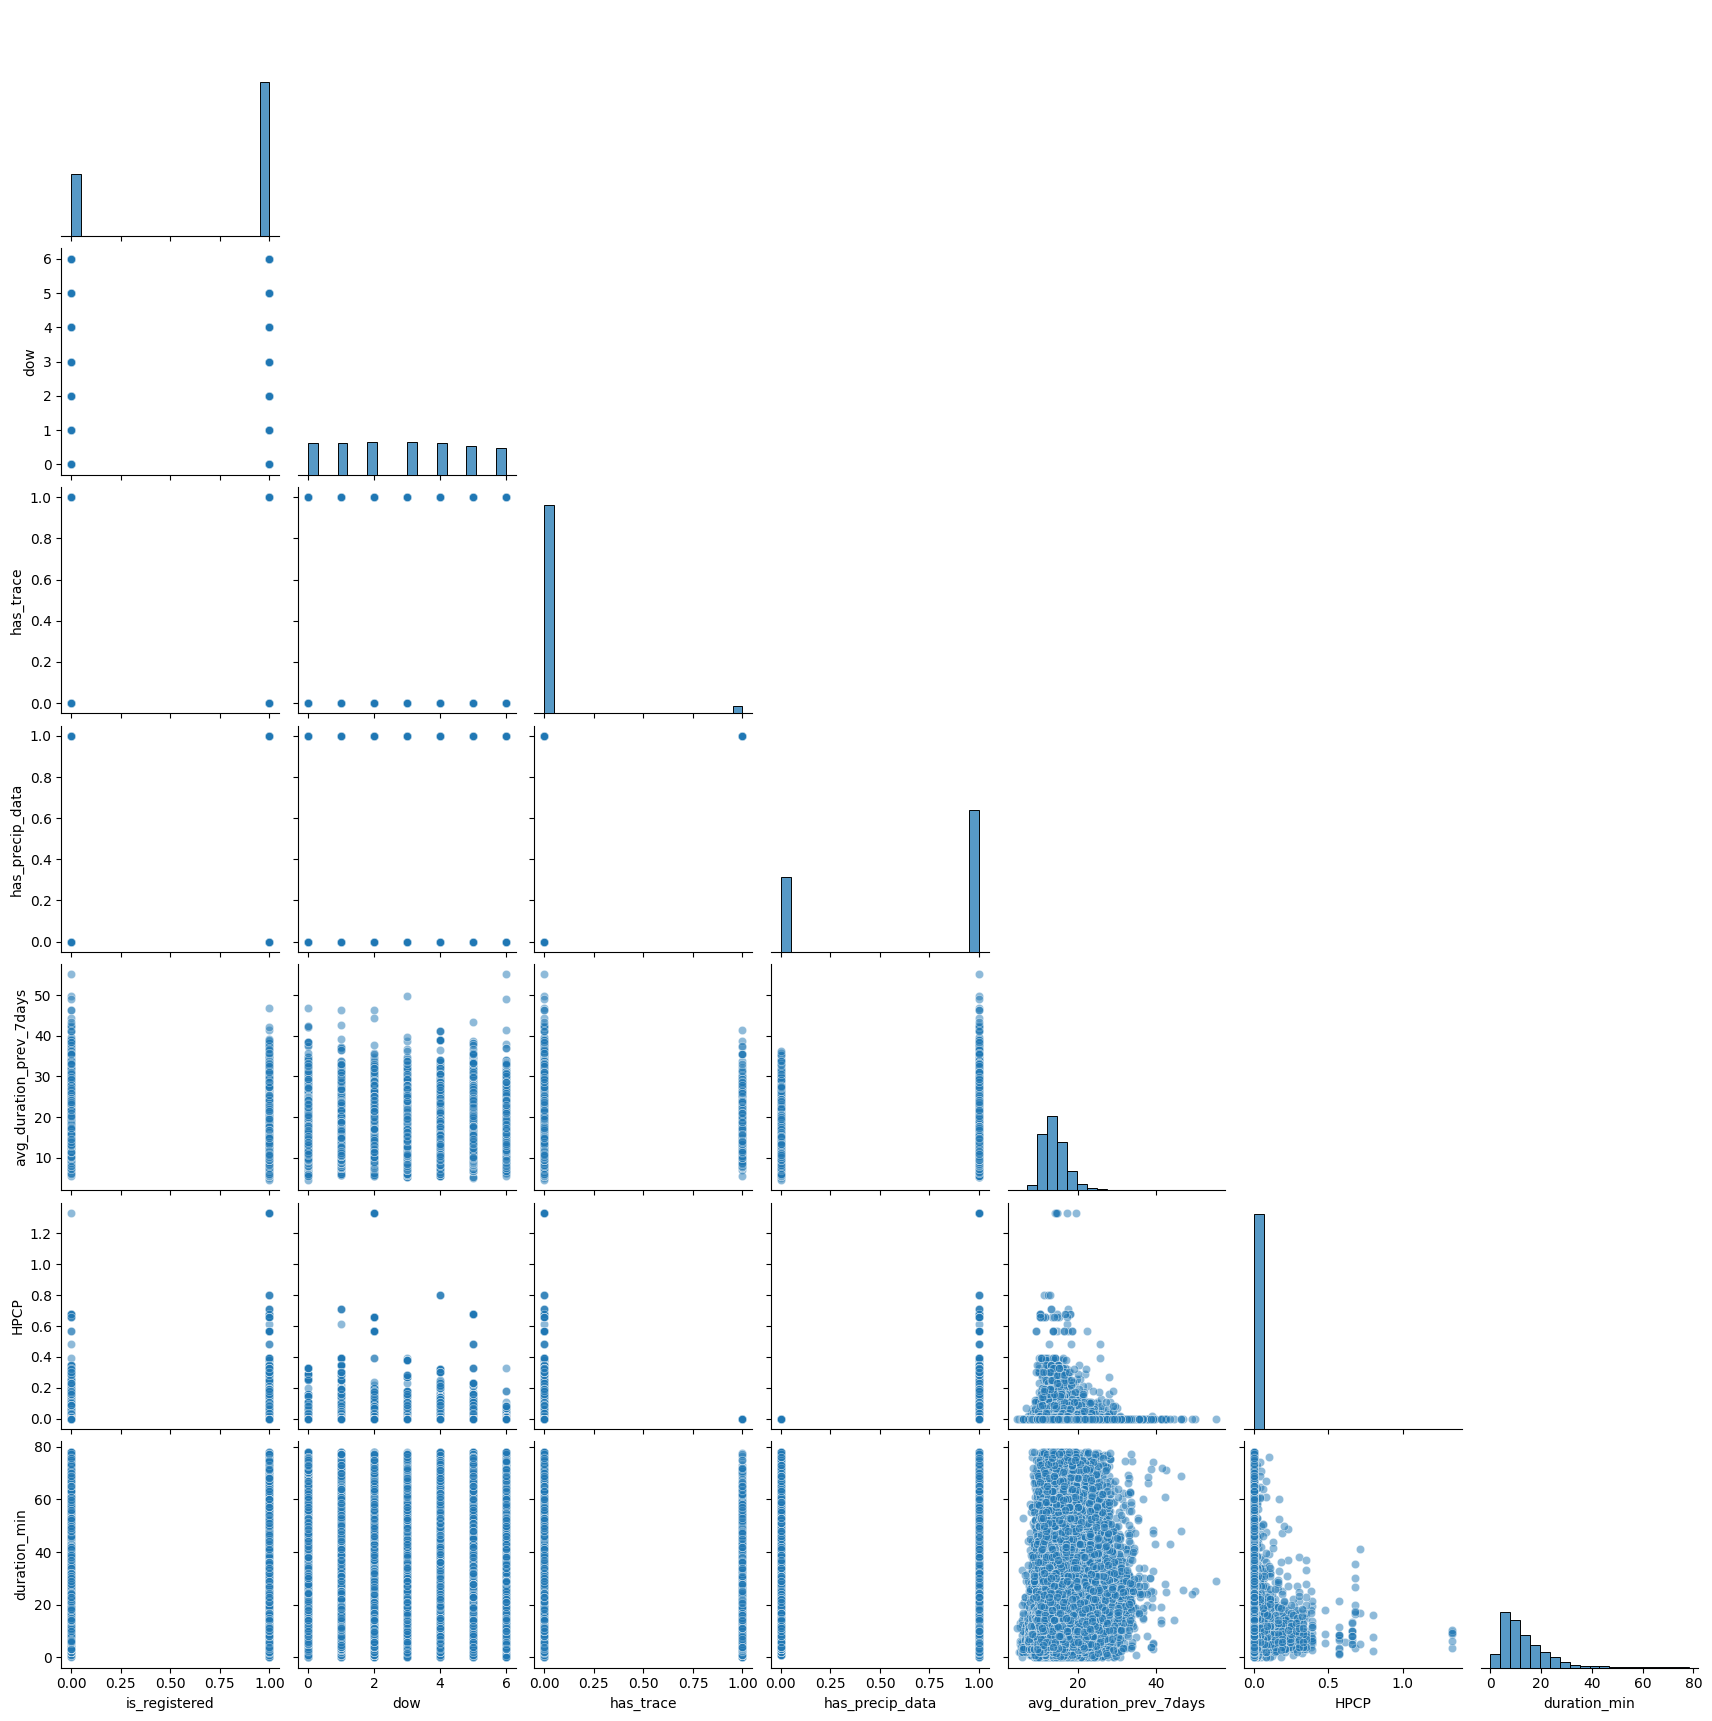

In [10]:
sns.pairplot(
    df.sample(frac=0.15),
    vars=cols_vars, diag_kws=dict(bins=20),
    plot_kws=dict(alpha=.5),
    corner=True)

## Periodicity 

- The trip time depends on the day of the week, with longer trip times happening during weekends. 
    - Two cyclic variables (`dow_sin` and `dow_cos`) are added to capture this. 
- There is a dependency on the month, with longer trips happening in spring and the summer. Overall, this pattern is likely caused by two underlying factors:
    - weather conditions (which are captured by other features)
    - holiday season (e.g. leading to a higher volume of leasure trips)

In [11]:
df.groupby('dow')[['duration_min']].agg(['mean', 'count']).reset_index()

dow duration_min        
              mean   count
0   0    12.911444  223858
1   1    12.164433  226824
2   2    12.305484  233400
3   3    12.480175  229698
4   4    13.111313  224935
5   5    17.365029  204737
6   6    17.408233  185101

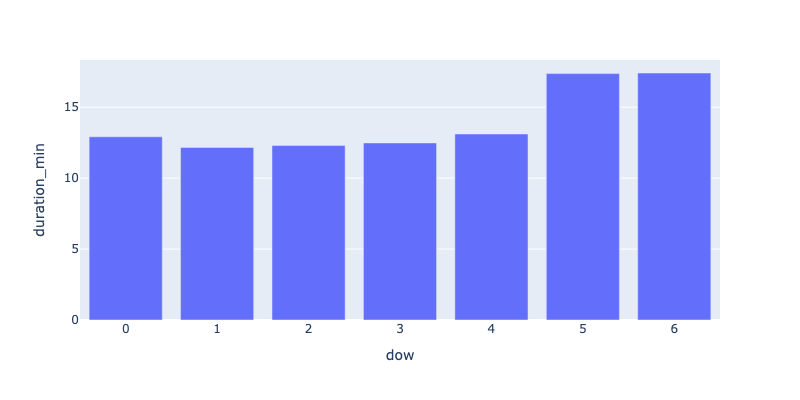

In [12]:
# Duration time seems to depend on day of the week, with longer trips happening during weekends.
# This justifies the creation of a cyclic variable.
df['dow'] = df['start_date'].dt.day_of_week
fig = px.bar(
    df.groupby('dow')[['duration_min']].mean().reset_index(),
    y='duration_min',
    x='dow',
)
fig.show(**plotly_show_opts)

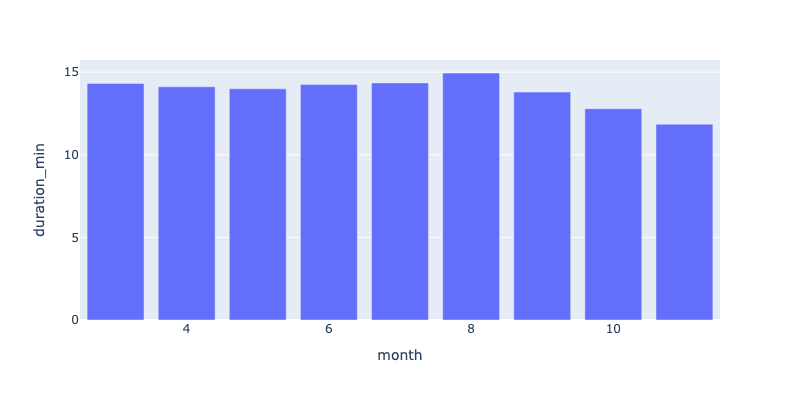

In [13]:
# Duration time seems to depend on day of the week, with longer trips happening during weekends.
# This justifies the creation of a cyclic variable.
df['month'] = df['start_date'].dt.month
fig = px.bar(
    df.groupby('month')[['duration_min']].mean().reset_index(),
    y='duration_min',
    x='month',
)
fig.show(**plotly_show_opts)

## Trend

As more hubs open, shorter routes are possible. This is observed in the average trip duration time going down. It also shows the importance of including in the model a feature that is indicative of the total number of hubs, or at least of the average trip duration time in the nearest past.

In [14]:
mask = df['strt_statn'] > 0
df_agg = df[mask].groupby('start_date_trunc')['duration_min'].agg(
    ['count', 'mean']).reset_index().sort_values('start_date_trunc')
df_agg['duration_min_7davg'] = df_agg['mean'].rolling(window=7).mean()

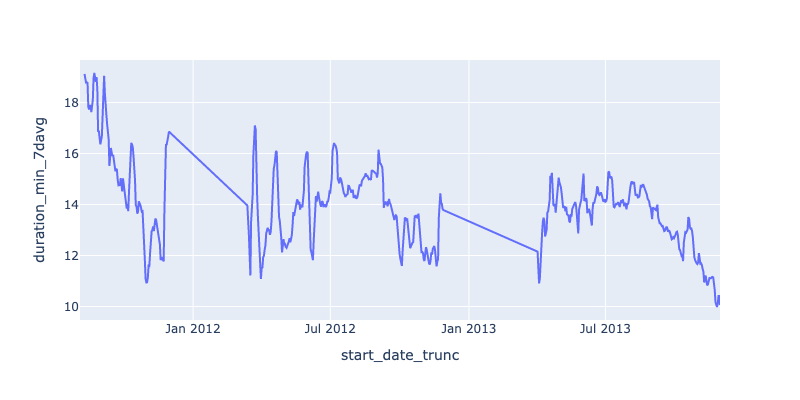

In [15]:
fig = px.line(df_agg, x='start_date_trunc', y='duration_min_7davg', hover_data=['count'])
fig.show(**plotly_show_opts)

## Subscription Type

Registered users take considerably shorter trips.

In [16]:
# fig = px.bar(
#     df[['is_registered', 'duration_min']].groupby('is_registered').agg(['count', 'mean']).reset_index(),
#     y='mean',
#     x='is_registered',

# )
# fig.show(**plotly_show_opts)
df[['is_registered', 'duration_min']].groupby('is_registered').agg(['count', 'mean'])

duration_min           
                     count       mean
is_registered                        
0                   436298  21.317468
1                  1092255  10.816391

## Precipitation data

To assess the impact on rain on the trip duration time, we exclude trips that hapened when weather data are not available (and for which we do not know the weather conditions).

The analysis shows a shrter trip duration with rain; this is counterintuitive at first, but can be explained as following:
- People only using the bikes for shorter trips;
- Only the most hardcore, and possibly fastest, riders are brave enough to venture on a trip. 
    - This is confirmed by the fact that with rain, the percentage of registered users increases considerably.

When weather data are not available, the trip duration is the shortest. This is possibly indicative of the fact that:
- Weather data were not available from Jul-2013. 
- This corresponds to the last period of collection of trip data, when the largest number of hubs was open, and shorter trips were possible.

Note that the more the rain, the lower the spread in trip duration.
- This is again linked by the fact that the more the rain, the higher the percentage of registered users who use the service.


In [17]:
df['has_rain'] = df['HPCP'] > 0.0
mask = df['has_precip_data'] == 1

df.groupby(['has_precip_data', 'has_rain'])['duration_min'].agg(['count', 'mean'])

count       mean
has_precip_data has_rain                   
0               False     527578  13.010059
1               False     973310  14.328035
                True       27665  11.045878

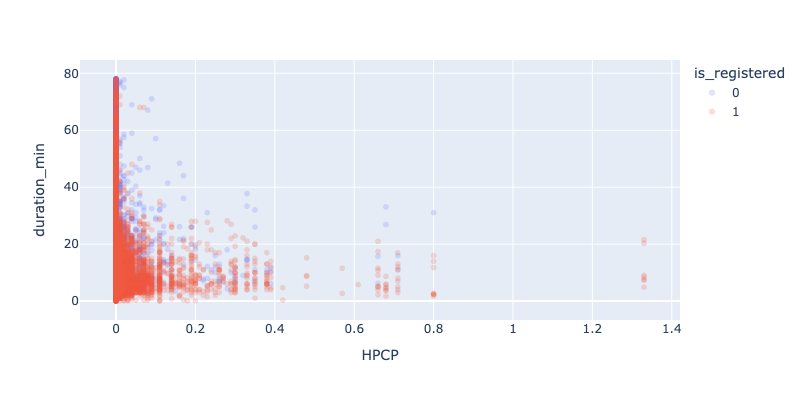

In [18]:
# Average trip length from start hub
df['is_registered'] = df['is_registered'].astype(str)
fig = px.scatter(df[df['has_precip_data'] == 1].sample(frac=.15), x='HPCP',
                 y='duration_min', opacity=.2, color='is_registered')
fig.show(**plotly_show_opts)

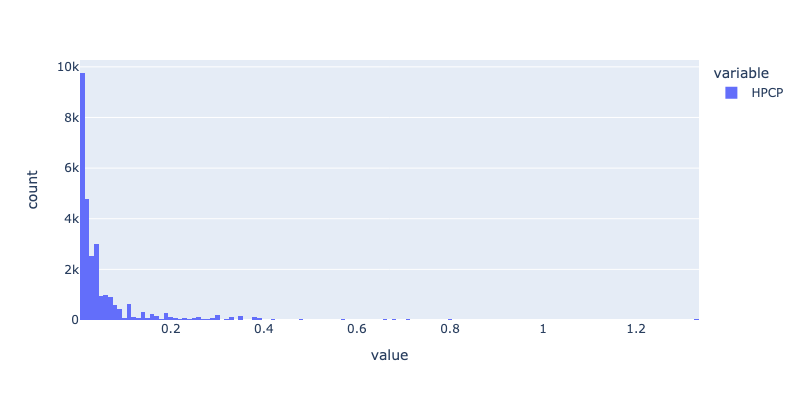

In [19]:
fig = df.loc[df['has_rain']]['HPCP'].hist(**pd_plot_optns)
fig.show(**plotly_show_opts)

## Avg. trip duration over previous 7 days window

The average trip duration is computed for each station separately (see [`src/lib_data_prep.py`](../src/lib_data_prep.py)); this feature tries to account for the fact that some hubs may be closer to other hubs, hence allowing for shorter routes. The feature depends not just on the hub, but also on the date, to account for the fact that new hubs have been opening in time (which changes the number, and distance, of potential destinations).

Overall, this feature can be mildly informative of the trip duration:
- For e.g., the top left region is empty, with the maximum observed trip duration growing with the `avg_duration_prev_7days`.
- Similarly, the density of points is lower in the region `avg_duration_prev_7days>20` and `duration<4`

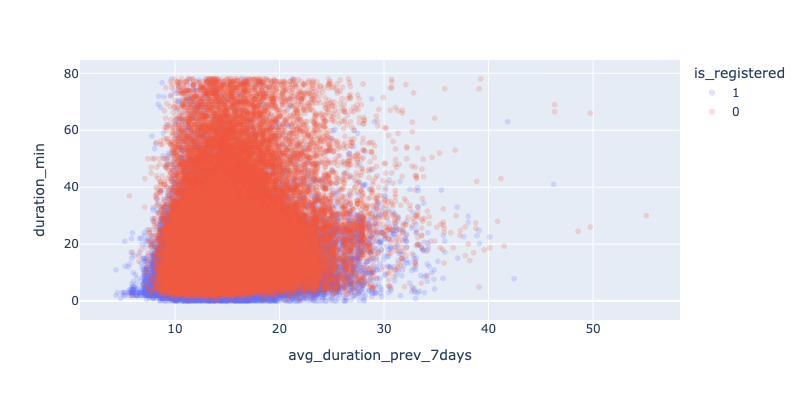

In [20]:
# Average trip length from start hub
fig = px.scatter(df.sample(frac=.15), x='avg_duration_prev_7days',
                 y='duration_min', opacity=.2, color='is_registered')
fig.show(**plotly_show_opts)